## Main Goal
The main goal of this project is identifying unusual or unexpected patterns within transactions or related activities.  
**Anomaly detection**, sometimes called outlier detection, is a process of finding patterns or instances in a dataset that deviate significantly from the expected or “normal behavior.”

### Data Understanding
The dataset contains information about various financial transactions, each represented by several features:

1. **Transaction_ID**: Unique identifier for each transaction.
2. **Transaction_Amount**: The monetary value of the transaction.
3. **Transaction_Volume**: The quantity or number of items/actions involved in the transaction.
4. **Average_Transaction_Amount**: The historical average transaction amount for the account.
5. **Frequency_of_Transactions**: How often transactions are typically performed by the account.
6. **Time_Since_Last_Transaction**: Time elapsed since the last transaction.
7. **Day_of_Week**: The day of the week when the transaction occurred.
8. **Time_of_Day**: The time of day when the transaction occurred.
9. **Age**: Age of the account holder.
10. **Gender**: Gender of the account holder.
11. **Income**: Income of the account holder.
12. **Account_Type**: Type of account (e.g., personal, business).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("datasets/transaction_anomalies_dataset.csv")

In [3]:
dataset.head(2)

,Transaction_ID,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Day_of_Week,Time_of_Day,Age,Gender,Income,Account_Type
0,TX0,1024.835708,3,997.234714,12,29,Friday,06:00,36,Male,1436074,Savings
1,TX1,1013.952065,4,1020.210306,7,22,Friday,01:00,41,Female,627069,Savings


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction_ID               1000 non-null   object 
 1   Transaction_Amount           1000 non-null   float64
 2   Transaction_Volume           1000 non-null   int64  
 3   Average_Transaction_Amount   1000 non-null   float64
 4   Frequency_of_Transactions    1000 non-null   int64  
 5   Time_Since_Last_Transaction  1000 non-null   int64  
 6   Day_of_Week                  1000 non-null   object 
 7   Time_of_Day                  1000 non-null   object 
 8   Age                          1000 non-null   int64  
 9   Gender                       1000 non-null   object 
 10  Income                       1000 non-null   int64  
 11  Account_Type                 1000 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 93.9+ KB


In [5]:
dataset.isnull().sum()

Transaction_ID                 0
Transaction_Amount             0
Transaction_Volume             0
Average_Transaction_Amount     0
Frequency_of_Transactions      0
Time_Since_Last_Transaction    0
Day_of_Week                    0
Time_of_Day                    0
Age                            0
Gender                         0
Income                         0
Account_Type                   0
dtype: int64

### Exploratory Data Analysis
#### What outliers exist in the distributions of Transaction_Amount and Transaction_Volume?

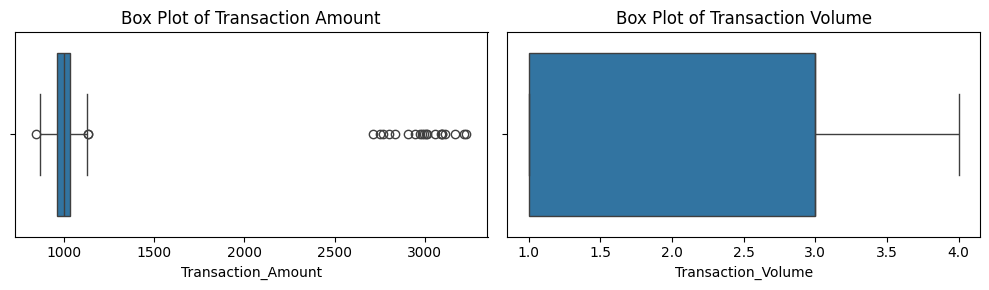

In [6]:
# Create a figure and axis
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
# Box plot for Transaction_Amount
sns.boxplot(data=dataset, x='Transaction_Amount', ax=axes[0])
axes[0].set_title('Box Plot of Transaction Amount')

# Box plot for Transaction_Volume
sns.boxplot(data=dataset, x='Transaction_Volume', ax=axes[1])
axes[1].set_title('Box Plot of Transaction Volume')

# Display the plots
plt.tight_layout()
plt.show()

> Transaction Volume boxplot shows that this feature doesn't have any outliers! However the boxplot of Transaction Amount shows accounts with transaction amount equal to or above 2600 considered to be outliers!  

#### Where does Transaction_Amount significantly deviate from the Average_Transaction_Amount for an account?

In [7]:
# Calculate the difference
dataset['Transaction_Deviation'] = dataset['Transaction_Amount'] - dataset['Average_Transaction_Amount']

In [8]:
# Define a threshold (e.g., 20% of the Average_Transaction_Amount)
threshold_percentage = 0.2
dataset['Significant_Deviation'] = dataset['Transaction_Deviation'].abs() > (threshold_percentage * dataset['Average_Transaction_Amount'])

In [9]:
# Filter the dataset for significant deviations
significant_deviations = dataset[dataset['Significant_Deviation']]

# Display the rows with significant deviations
# significant_deviations.shape[1] 14 observations
significant_deviations.head(2)

,Transaction_ID,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Day_of_Week,Time_of_Day,Age,Gender,Income,Account_Type,Transaction_Deviation,Significant_Deviation
59,TX59,2769.890232,3,1007.261392,17,23,Monday,02:00,58,Male,1198320,Current,1762.628840,True
147,TX147,2802.097817,2,995.475096,12,19,Sunday,20:00,34,Female,694966,Savings,1806.622721,True


> There are 14 observations that have significant deviation!

#### How does Frequency_of_Transactions vary across Account_Type, and do any accounts exhibit unusual frequencies?

In [10]:
# Group by Account_Type and calculate summary statistics
summary_stats = dataset.groupby('Account_Type')['Frequency_of_Transactions'].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
Account_Type,,,,,,,,
Current,516.0,11.775194,4.254049,5.0,8.0,12.0,15.0,19.0
Savings,484.0,12.400826,4.216265,5.0,9.0,12.0,16.0,19.0


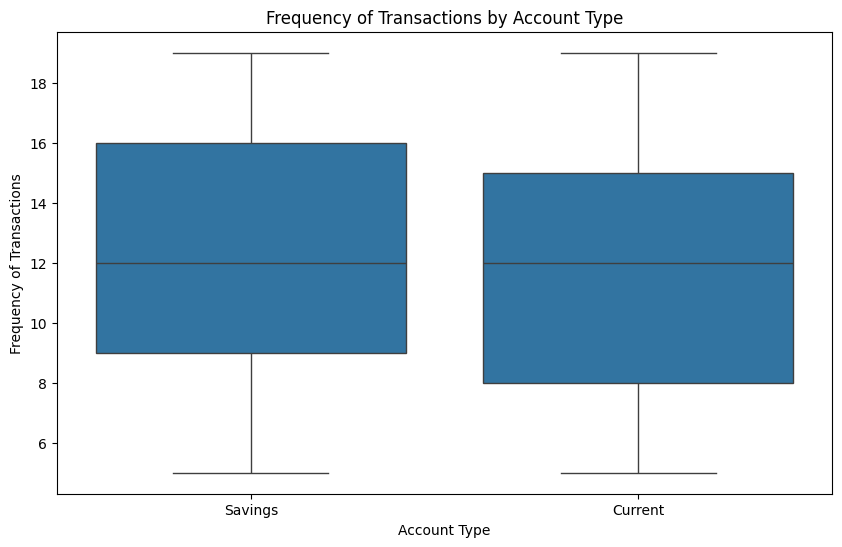

In [11]:
# Visualization using box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x='Account_Type', y='Frequency_of_Transactions')
plt.title('Frequency of Transactions by Account Type')
plt.xlabel('Account Type')
plt.ylabel('Frequency of Transactions')
plt.show()

> Based on the close means and almost identical standard deviations, we can infer that the frequency of transactions is quite similar for both Current and Savings account types.  
This suggests that there isn't a significant difference in transaction behavior between the two account types, indicating consistency in how often transactions are performed.  

#### Do patterns in Time_Since_Last_Transaction reveal sudden large transactions after periods of inactivity?

In [12]:
dataset_cpy = dataset.copy()

In [13]:
# Sort dataset by account and transaction time. Making sure that transactions for each account type are ordered chronologically, 
# This way, we can accurately calculate the difference between consecutive transactions for each account.
dataset_cpy = dataset_cpy.sort_values(by=['Account_Type', 'Time_Since_Last_Transaction'])

# Calculate the difference in Transaction_Amount from the previous transaction
dataset_cpy['Transaction_Diff'] = dataset_cpy.groupby('Account_Type')['Transaction_Amount'].diff()
# By grouping the transactions by Account_Type, we ensure that differences are calculated within each account type, not across different accounts. 
# This avoids comparing transactions from different accounts, ensuring the analysis remains accurate and relevant to each individual account type.

In [14]:
# Define a threshold for large transactions (e.g., 2 times the average transaction amount)
average_transaction_amount = dataset_cpy['Transaction_Amount'].mean()
large_transaction_threshold = 2 * average_transaction_amount

In [15]:
# Flag large transactions
dataset_cpy['Large_Transaction'] = dataset_cpy['Transaction_Amount'] > large_transaction_threshold

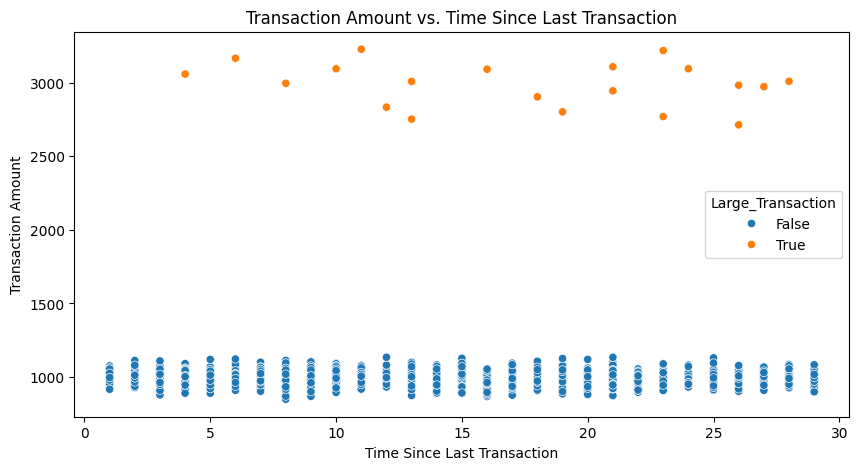

In [16]:
# Scatter plot to observe the relationship between Time_Since_Last_Transaction and Transaction_Amount
plt.figure(figsize=(10, 5))
sns.scatterplot(data=dataset_cpy, x='Time_Since_Last_Transaction', y='Transaction_Amount', hue='Large_Transaction')
plt.title('Transaction Amount vs. Time Since Last Transaction')
plt.xlabel('Time Since Last Transaction')
plt.ylabel('Transaction Amount')
plt.show()

> There are 20 transactions identified with significant deviations, represented by orange circles around a Transaction_Amount of approximately 3000.   
These 20 transactions are indicative of a pattern where certain accounts exhibit large transactions following long periods of no activity. This could be a flag for further investigation, as it may point to anomalous behavior or specific account activities that warrant closer scrutiny.

#### Are there unusual spikes in Transaction_Amount based on Time_of_Day or Day_of_Week?

In [21]:
# Calculate summary statistics for Transaction_Amount based on Time_of_Day and Day_of_Week
time_stats = dataset.groupby('Time_of_Day')['Transaction_Amount'].describe()
day_stats = dataset.groupby('Day_of_Week')['Transaction_Amount'].describe()

In [22]:
time_stats.head()

,count,mean,std,min,25%,50%,75%,max
Time_of_Day,,,,,,,,
00:00,36.0,1054.180100,352.565091,908.415888,971.139163,997.205361,1026.967168,3091.310338
01:00,40.0,1007.167239,37.813933,935.342923,979.105660,1006.292417,1034.224871,1090.584603
02:00,44.0,1040.683808,270.919497,922.328610,964.938934,1001.581012,1048.185703,2769.890232
03:00,47.0,1024.505359,261.722577,869.789307,957.106813,989.700514,1015.495863,2752.637650
04:00,47.0,1029.633205,314.202845,897.778849,951.621877,987.079964,1013.471925,3108.424034


In [23]:
day_stats.head()

,count,mean,std,min,25%,50%,75%,max
Day_of_Week,,,,,,,,
Friday,143.0,1000.577528,52.888368,876.417775,957.967379,1002.677032,1038.356210,1119.451798
Monday,132.0,1054.917298,347.938338,868.810588,965.187092,997.895165,1028.133678,3166.250653
Saturday,127.0,1058.819426,335.790028,849.024392,966.522053,1003.392776,1036.097924,3094.646173
Sunday,145.0,1070.115473,374.959044,869.789307,968.498751,1005.779900,1042.922556,3218.959781
Thursday,148.0,1056.614627,337.411251,890.019464,970.992310,1007.195432,1028.795720,3227.459108


In [24]:
overall_mean = dataset['Transaction_Amount'].mean()

# Define a threshold for what constitutes a significant spike (e.g., 1.5 times the overall mean)
spike_threshold = 1.5 * overall_mean

In [28]:
print(spike_threshold)

1557.183766125308


In [25]:
# Flag times and days with significant spikes
unusual_times = dataset[dataset['Transaction_Amount'] > spike_threshold]
unusual_days = dataset[dataset['Transaction_Amount'] > spike_threshold]

In [ ]:
# Display the rows with unusual spikes
unusual_times.head()
# The same as unusual_days
# unusual_days.()

,Transaction_ID,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Day_of_Week,Time_of_Day,Age,Gender,Income,Account_Type,Transaction_Deviation,Significant_Deviation
59,TX59,2769.890232,3,1007.261392,17,23,Monday,02:00,58,Male,1198320,Current,1762.628840,True
147,TX147,2802.097817,2,995.475096,12,19,Sunday,20:00,34,Female,694966,Savings,1806.622721,True
188,TX188,3094.817415,3,980.424667,6,10,Sunday,11:00,57,Female,1158058,Current,2114.392748,True
230,TX230,2752.637650,4,1020.914703,11,13,Saturday,03:00,57,Male,1460932,Savings,1731.722947,True
246,TX246,3008.497489,4,1010.593855,16,13,Sunday,13:00,37,Male,551537,Current,1997.903634,True
